# CSGY 6953 Deep Learning Final Project
In this project, we will implement a dual-encoder model for image search. Our model will be trained so that it embeds both images and texts into the same space, and importantly, maps relevant data to be close each other in the embedding space. This will be done by developing two encoders, one for image processing and the other for text encoding, and training them by a similarity-based loss function.<br>
<br>
In this note book, we build our best model based on the result we got in the ablation study. <br>
Major points include <br>
* Xception as image encoder
* BERT as text encoder
* BatchNorm as final output conversion
* 8 negative pairs per positive pair
* The use of negative pairs shuffling

## 1. Preparation
As always, prepare the dataset for the training.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sys

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
with open(f"drive/My Drive/finalproj/data/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)

In [4]:
# Split them into training and test sets.
train_pct = 0.7
threshold = int(len(dataset["images"]) * train_pct)
train_images = dataset["images"][:threshold]
train_texts = dataset["texts"][:threshold * 10]
test_images = dataset["images"][threshold:]
test_texts = dataset["texts"][threshold * 10:]
print(f"Training images: ", len(train_images))
print(f"Training texts: ", len(train_texts))
print(f"Test images: ", len(test_images))
print(f"Test texts: ", len(test_texts))

Training images:  3150
Training texts:  31500
Test images:  1350
Test texts:  13500


In [5]:
import torch
from torch.utils.data import DataLoader

In [6]:
# These are the libraries we developed from scratch for this project.
sys.path.append("drive/My Drive/finalproj")
import EncoderHeads, Dataset, utils

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The device is " + device.type + ".")

The device is cuda.


In [10]:
# This time, choose Xception for the image encoder instead of InceptionV3.
embed_dim = 256
max_len = 60 # Recommend: 46 for GloVe, 60 for BERT (though the maximum is 146)
image_encoder_model = "Xception"
text_encoder_model = "BERT"
image_head_model = "FC_BatchNorm"
text_head_model = "FC_BatchNorm"

TrainingDataset = Dataset.DualEncoderDataset(train_images, train_texts, device, image_encoder_model, text_encoder_model, max_len=max_len, neg_rate=8)
TestDataset = Dataset.DualEncoderDataset(test_images, test_texts, device, image_encoder_model, text_encoder_model, max_len=max_len, neg_rate=8)
TrainingDataset.print_num_params()


Preprocessing image data...


100%|██████████| 99/99 [00:27<00:00,  3.54it/s]


Preprocessing text data...


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

100%|██████████| 985/985 [00:50<00:00, 19.69it/s]



Preprocessing image data...


100%|██████████| 43/43 [00:11<00:00,  3.74it/s]


Preprocessing text data...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 422/422 [00:20<00:00, 20.11it/s]


=== Image Encoder ===
  Pretrained Parameters: 20,806,952

=== Text Encoder ===
  Pretrained Parameters: 109,482,240


In [13]:
epochs = 30
batch_size = 128
train_loss = []
eval_loss = []
trainloader = DataLoader(TrainingDataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(TestDataset, batch_size=batch_size, shuffle=True)

image_head = EncoderHeads.EncoderHead(image_head_model, TrainingDataset.image_encoder_output_size, embed_dim).to(device)
text_head = EncoderHeads.EncoderHead(text_head_model, TrainingDataset.text_encoder_output_size, embed_dim).to(device)
print(f"=== Image Encoder Head ===")
print(f"  Trainable Parameters: {image_head.num_parameters:,}")
print(f"\n=== Text Encoder Head ===")
print(f"  Trainable Parameters: {text_head.num_parameters:,}")

criterion = torch.nn.CosineEmbeddingLoss(margin=0.1, reduction='sum') # Recipe 1M+ paper sets margin=0.1.
image_optimizer = torch.optim.Adam(image_head.parameters(), lr=0.0005)
text_optimizer = torch.optim.Adam(text_head.parameters(), lr=0.0005)

=== Image Encoder Head ===
  Trainable Parameters: 1,180,928

=== Text Encoder Head ===
  Trainable Parameters: 525,568


## 2. Training

In [14]:
print("Start Training...")
for epoch in range(epochs):
    trainloader.dataset.shuffle() # Do shuffling.
    trainloss = utils.train(trainloader, image_head, text_head, image_optimizer, text_optimizer, criterion)
    train_loss.append(trainloss)
    evalloss, _ = utils.eval(testloader, image_head, text_head, criterion)
    eval_loss.append(evalloss)
    if (epoch + 1) % 2 == 0:
        print(f"Epoch: {epoch + 1} | Training loss: {trainloss:.4f} | Test loss: {evalloss:.4f}")
_, sim_mat = utils.eval(testloader, image_head, text_head, criterion, only_loss=False)

Start Training...
Epoch: 2 | Training loss: 0.0785 | Test loss: 0.0815
Epoch: 4 | Training loss: 0.0665 | Test loss: 0.0760
Epoch: 6 | Training loss: 0.0600 | Test loss: 0.0737
Epoch: 8 | Training loss: 0.0559 | Test loss: 0.0706
Epoch: 10 | Training loss: 0.0518 | Test loss: 0.0678
Epoch: 12 | Training loss: 0.0486 | Test loss: 0.0660
Epoch: 14 | Training loss: 0.0457 | Test loss: 0.0640
Epoch: 16 | Training loss: 0.0428 | Test loss: 0.0631
Epoch: 18 | Training loss: 0.0412 | Test loss: 0.0619
Epoch: 20 | Training loss: 0.0391 | Test loss: 0.0616
Epoch: 22 | Training loss: 0.0377 | Test loss: 0.0609
Epoch: 24 | Training loss: 0.0365 | Test loss: 0.0615
Epoch: 26 | Training loss: 0.0358 | Test loss: 0.0615
Epoch: 28 | Training loss: 0.0347 | Test loss: 0.0602
Epoch: 30 | Training loss: 0.0337 | Test loss: 0.0608


In [21]:
with open(f"drive/My Drive/finalproj/base_model_loss.pkl", "rb") as f:
    base_model_loss = pickle.load(f)

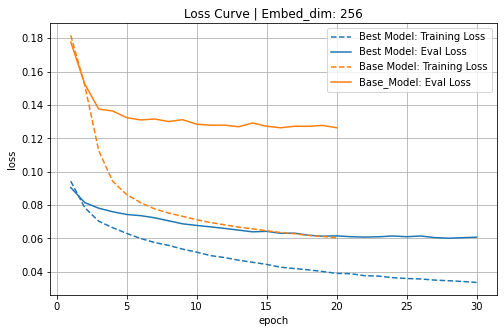

In [23]:
# Plot the loss curves.
plt.figure(figsize=(8,5))
plt.plot(np.arange(1, epochs + 1), train_loss, label="Best Model: Training Loss", color=plt.cm.tab10(0), linestyle="dashed")
plt.plot(np.arange(1, epochs + 1), eval_loss, label="Best Model: Eval Loss", color=plt.cm.tab10(0))
plt.plot(np.arange(1, 21), base_model_loss["training"], label="Base Model: Training Loss", color=plt.cm.tab10(1), linestyle="dashed")
plt.plot(np.arange(1, 21), base_model_loss["test"], label="Base_Model: Eval Loss", color=plt.cm.tab10(1))
plt.title(f"Loss Curve | Embed_dim: {embed_dim}")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.legend()
plt.show()

## 3. Performance

Image Retrieval From Text:
   Median Rank: 13.0 / 1350
   Recall at K: 0.4250
Text Retrieval From Image:
   Median Rank: 139.0 / 13500
   Recall at K: 0.0893


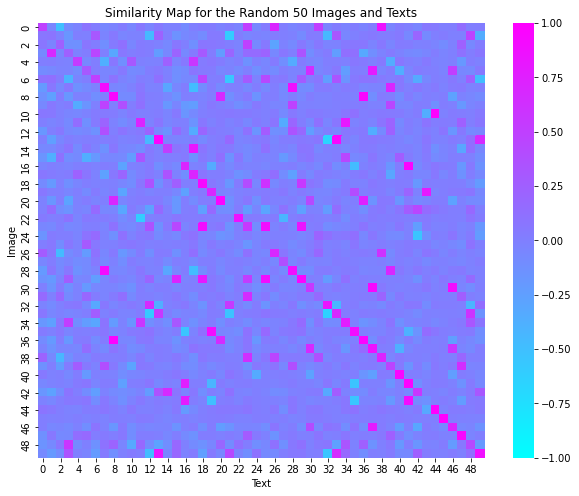

In [16]:
utils.show_performance(testloader, sim_mat)

Query Image:


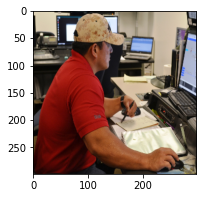

CosSim=0.8754 | a computer screen is showing a blue screen
CosSim=0.8690 | A person working at a laptop, with what appears to be sound equipment.
CosSim=0.8469 | A man looking at the camera wearing an astronaut outfit. 
CosSim=0.8271 | Three people in a room with a camera near windows.
CosSim=0.8232 | A man standing and looking through a video camera.
CosSim=0.8196 | The computer displays the incoming data as the wireless arm sensors are activated 
CosSim=0.8176 | A man playing on a keyboard with computer equipment around him. 
CosSim=0.8125 | A laptop computer displaying instructions on the monitor. 
CosSim=0.8114 | A monitor sitting on the desk of a computer
CosSim=0.8098 | A person staring at the screen of a computer and holding the  mouse 


Query Image:


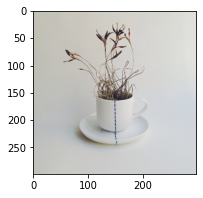

CosSim=0.9768 | A flower plant is in a green vase. 
CosSim=0.9753 | A plant with red flower inside a green vase 
CosSim=0.9742 | The flowers that are pink are in the vase.
CosSim=0.9738 | Light pink flowers with green leafy stems sit in a tall glass vase full of water.
CosSim=0.9733 | A cluster of red, pink and yellow flowers sits in a glass of water in front of a window with blinds.
CosSim=0.9703 | plant placed inside of a vase with pink flower's
CosSim=0.9676 | A bonsai plant is growing in a pot on a small table.
CosSim=0.9662 | An orange rose sits in front of the rose bush.
CosSim=0.9658 | A large flower arrangement in a large glass vase.
CosSim=0.9599 | Bouquet of pink, red, and yellow flowers in a glass vase.


Query Image:


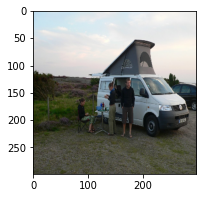

CosSim=0.9502 | The car is black in color and is parked near a white truck. 
CosSim=0.9473 | A red car is parked in front of the dumpsters.
CosSim=0.9468 | A red car is parked on the side of the road next to trash cans. 
CosSim=0.9458 | A silver off road vehicle parked on a gravel parking lot. 
CosSim=0.9435 | A white camper parked in a wooded area.
CosSim=0.9411 | a white vehicle parked on the right side of the road
CosSim=0.9399 | A black truck is parked on a driveway by some green shrubs.
CosSim=0.9373 | A black suv is parked on the side of the road with its back and side doors open. 
CosSim=0.9332 | A black SUV in a parking lot with many other cars.
CosSim=0.9311 | A blue vehicle is parked face to face with a brown vehicle.


Query Image:


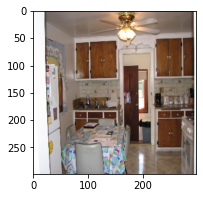

CosSim=0.8345 | An antique chest of drawers sitting in a store with other furniture around it.
CosSim=0.8098 | A room with wooden walls and shelves. 
CosSim=0.8006 | Corner of a room with a book shelf, a banner and a mini fridge.
CosSim=0.8000 | A room with a lot of different furniture and cabinets. 
CosSim=0.7914 | A shelf in a pantry full of bottles and jars.
CosSim=0.7890 | Brownish green cabinets hold Christmas objects on a shelf.
CosSim=0.7798 | A room filled with two mattresses, table and three chests.
CosSim=0.7747 | An empty set of shelves with peeled off paint. 
CosSim=0.7733 | Many jars and containers clutter counter tops and shelf space.
CosSim=0.7733 | A green cabinet has items on top of it.


Query Image:


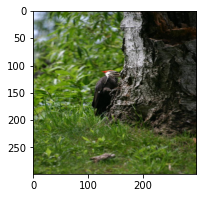

CosSim=0.9750 | Blue and white bird standing in bird feeder on a sunny day.
CosSim=0.9675 | A pair of geese float close to each other. 
CosSim=0.9628 | A white bird is holding its wings out over the water.
CosSim=0.9627 | Large grey black and white bird standing outside.
CosSim=0.9583 | A bird with blue feathers is standing on a wooden ledge.
CosSim=0.9577 | An eagle, a leash on it legs, flies above the grass.
CosSim=0.9575 | Two black birds are sitting in a chair while another black bird is flying. 
CosSim=0.9575 | A small black and white bird is standing in a field.
CosSim=0.9554 | A black and white bird stands on the ground.
CosSim=0.9544 | A black and white bird standing on the ground.




In [17]:
utils.TextFromImage(sim_mat, test_images, test_texts)

Query Text: Two wrestles struggle with each other as people watch. 


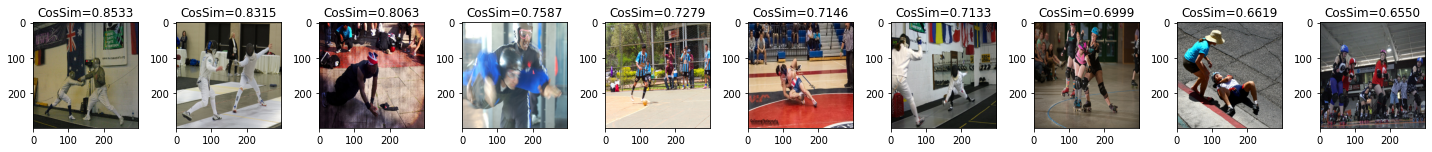



Query Text: the two grey filing cabinets are located against the wall 


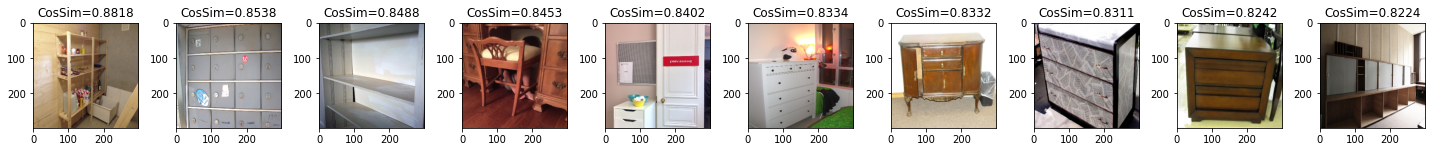



Query Text: A dark colored scorpion standing atop dirt in a manmade habitat.


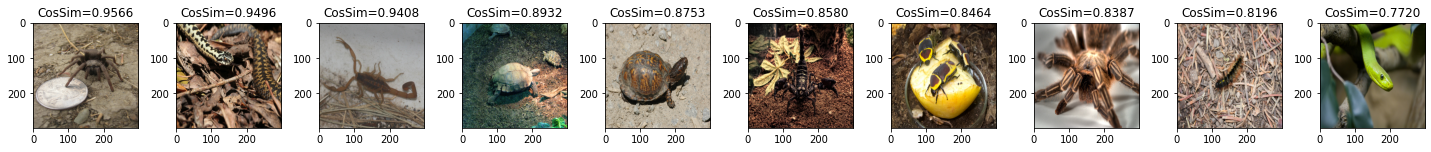



Query Text: A man in glasses and a scarf holds a camcorder. 


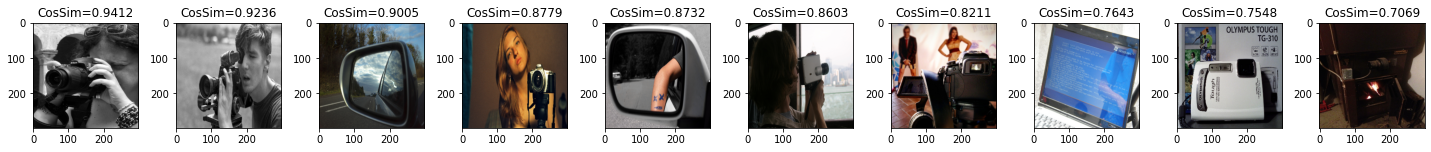



Query Text: A man and kid looking inside a helicopter.


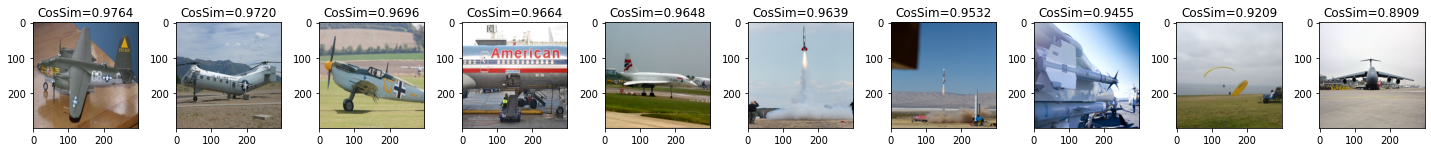

In [18]:
utils.ImageFromText(sim_mat, test_images, test_texts)

In [19]:
train_image_embeddings, train_text_embeddings = utils.proj(trainloader, image_head, text_head)
test_image_embeddings, test_text_embeddings = utils.proj(testloader, image_head, text_head)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


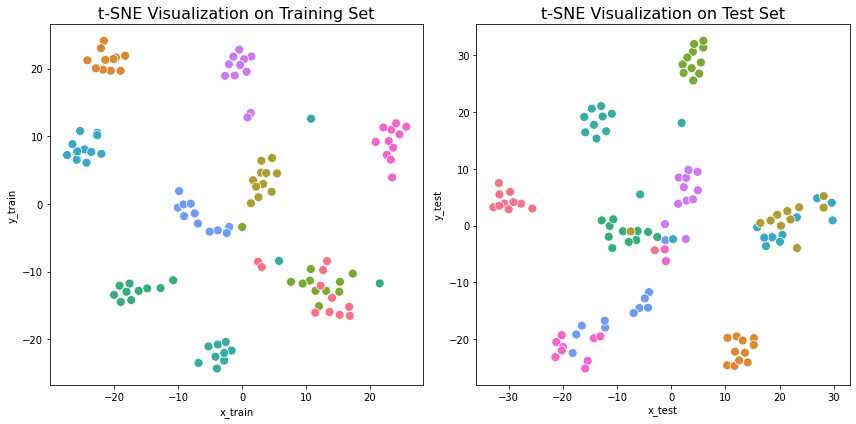

In [20]:
utils.tSNE_visualization(train_image_embeddings, train_text_embeddings, test_image_embeddings, test_text_embeddings)